<a href="https://colab.research.google.com/github/trituenhantaoio/DeepLearning-Tutorial/blob/master/Ph%C3%A2n_lo%E1%BA%A1i_%E1%BA%A3nh_v%E1%BB%9Bi_PyTorch_(P1)_trituenhantao_io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Huấn luyện bộ phân lớp
=====================

Trong bài này, bạn sẽ được quan sát cách định nghĩa mạng nơ ron, tính toán loss và cập nhật trọng số mạng.

----------------

Nhìn chung, khi xử lý dữ liệu ảnh, văn bản, audio, video, bạn có thể sử dụng các gói python chuẩn để nạp dữ liệu vào mảng numpy và sau đó chuyển đổi sang ``torch.*Tensor``.

Một số thư viện gợi ý cho bạn:
-  Dữ liệu ảnh: Pillow, OpenCV
-  Dữ liệu audio: scipy and librosa
-  Dữ liệu văn bản: NLTK, SpaCy hoặc Python thuần

Đặc biệt với dữ liệu ảnh, PyTorch có gói mang tên
``torchvision``, được cài đặt sẵn các gói nạp data cho các dataset nổi tiếng như Imagenet, CIFAR10, MNIST, v..v.. cũng như các gói xử lý ảnh, video như ``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

Điều này mang đến sự tiện lợi và hạn chế việc lặp lại các đoạn code.

Trong bài này, chúng ta sẽ sử dụng bộ dataset CIFAR10.
Nó có các lớp: ‘airplane’ (máy bay), ‘automobile’ (xe mô tô), ‘bird’ (chim), ‘cat’ (mèo), ‘deer’ (hươu),
‘dog’ (chó), ‘frog’ (ếch), ‘horse’ (ngựa), ‘ship’ (tàu thủy), ‘truck’ (xe tải). Các ảnh có kích thước 3x32x32, với 3 kênh màu, rộng 32, cao 32.



Huấn luyện bộ phân lớp ảnh
----------------------------

Chúng ta sẽ thực hiện các bước sau:

1. Nạp và chuẩn hóa bộ train và test của CIFAR10 thông qua   ``torchvision``
2. Định nghĩa một mạng tích chập (CNN)
3. Định nghĩa hàm loss
4. Huấn luyện với bộ train
5. Kiểm thử với bộ test





1. Đầu tiên, ta sẽ nạp và chuẩn hóa dataset

Sử dụng ``torchvision``, việc nạp CIFAR10 rất đơn giản.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

Đầu ra của các dataset trong torchvision là ảnh PILImage trong khoảng giá trị [0, 1].
Chúng ta chuyển đổi chúng thành dạng Tensor với khoảng giá trị chuẩn [-1, 1].

Lưu ý: Nếu bạn sử dụng Windows và gặp lỗi BrokenPipeError, hãy thử đặt num_worker trong torch.utils.data.DataLoader() về 0.



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Giờ chúng ta sẽ hiển thị thử một vài tấm ảnh cùng nhãn của chúng.

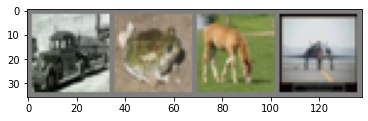

truck  frog horse plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Định nghia một mạng nơ ron tích chập
Chúng ta sẽ dùng lại code trong bài trước và chỉnh sửa đề nhận vào ảnh có 3 kênh màu.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Định nghĩa hàm loss và hàm tối ưu

Chúng ta sẽ sử dụng Classification Cross-Entropy và SGD với momentum. Thay vì chỉ sử dụng gradient trong bước hiện tại, momentum sẽ cộng dồn gradient của các bước trước đó để định hướng tối ưu.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Huấn luyện mô hình


Đây là bước mọi thứ trở nên thú vị. Chúng ta có một vòng lặp qua các mẫu của dữ liệu, truyền input vào mạng và tối ưu trọng số. Ta sẽ đo thời gian huấn luyện trên CPU.



In [ ]:
import time

start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training. Total time: ',time.time()-start)

[1,  2000] loss: 2.222
[1,  4000] loss: 1.920
[1,  6000] loss: 1.674
[1,  8000] loss: 1.597
[1, 10000] loss: 1.526
[1, 12000] loss: 1.473
[2,  2000] loss: 1.405
[2,  4000] loss: 1.378
[2,  6000] loss: 1.327
[2,  8000] loss: 1.304
[2, 10000] loss: 1.275
[2, 12000] loss: 1.261
Finished Training. Total time:  120.2777669429779


Lưu mô hình đã huấn luyện bằng `torch.save`

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Xem thêm về việc lưu mô hình trong PyTorch [tại đây](https://pytorch.org/docs/stable/notes/serialization.html).

5. Đánh giá mạng với dữ liệu test

Chúng ta đã huấn luyện mô hình với 2 vòng lặp qua toàn bộ dataset. Chúng ta cần kiểm tra xem mô hình có học được gì không.

Ta sẽ kiểm tra với nhãn của lớp được sinh ra bởi mạng nơ ron so với nhãn chuẩn (GroundTruth). 

Đầu tiên, ta sẽ hiển thị ảnh trong tập test.



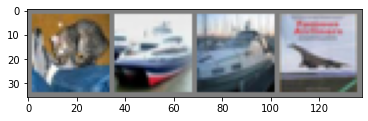

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Tiếp theo, ta sẽ nạp lại mô hình đã lưu trước đó. Thực tế thì việc này không cần thiết, và bước này chỉ có giá trị minh họa:



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Giờ ta sẽ xem mạng nơ ron cho rằng các hình ảnh trên là vật gì?

In [ ]:
outputs = net(images)

Output là dự đoán trên 10 lớp. Giá trị dự đoán của một lớp càng cao tức là mô hình nghĩ rằng hình ảnh nên thuộc về lớp đó, do đó ta cần lấy `max`:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


Giờ ta sẽ xem mạng nơ ron đoán chính xác bao nhiêu trên toàn tập test.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Nếu như đoán ngẫu nhiên, mô hình sẽ có độ chính xác khoảng 10%. Như vậy, có thể thấy là mô hình đã học được từ dữ liệu, nhưng chưa tuyệt đối hoàn hảo.

Giờ ta cần phân tích xem mô hình hoạt động tốt và hoạt động kém trên những nhãn nào:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 68 %
Accuracy of  bird : 67 %
Accuracy of   cat : 28 %
Accuracy of  deer : 17 %
Accuracy of   dog : 43 %
Accuracy of  frog : 68 %
Accuracy of horse : 63 %
Accuracy of  ship : 69 %
Accuracy of truck : 52 %
